# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusion](#conclusion)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.groupby(['group', 'landing_page'])['user_id'].nunique()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145310
           old_page          1965
Name: user_id, dtype: int64

**f.** Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

# Storing the drop condition in a variable since it is long
drop_cond = ((df['group']=='control')&(df['landing_page']=='new_page'))
drop_cond = drop_cond | ((df['group']=='treatment')&(df['landing_page']=='old_page'))
df2 = df.drop(df[drop_cond].index)

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
_dup_id = df2[df2['user_id'].duplicated()]['user_id']
_dup_id.iloc[0]

773192

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df2[df2['user_id']==_dup_id.iloc[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# getting the indices of the rows with the duplicated id
_dup_indices = df2[df2['user_id']==_dup_id.iloc[0]].index

# Remove one of the rows with a duplicate user_id..
df2 = df2.drop(_dup_indices[1])

# resetting the indices in the dataframe after dropping
df2 = df2.reset_index(drop=True)

# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id']==_dup_id.iloc[0]]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [14]:
p_population = df2.converted.mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
_ctrl_conv = df2.query('group == "control"')['converted'].mean()
_ctrl_conv

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
_treat_conv = df2.query('group == "treatment"')['converted'].mean()
_treat_conv

0.11880806551510564

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = _treat_conv - _ctrl_conv
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [18]:
(df2['landing_page']=='new_page').mean()

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**No, The Mean Conversion rate for the Control Group is Higher.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**$H_0: p_{new} - p_{old} <= 0$**<br>
>**$H_1: p_{new} - p_{old} > 0$**

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
p_new = p_population
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
p_old = p_population
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [21]:
n_new = df2.query('group=="treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.query('group=="control"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [23]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], p=[1-p_new, p_new], size=n_new)

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], p=[1-p_old, p_old], size=n_old)

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.0021246319950732756


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [26]:
# Sampling distribution 
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], p=[1-p_new, p_new], size=n_new)
    old_page_converted = np.random.choice([0,1], p=[1-p_old, p_old], size=n_old)
    
    # For each sample, calculating conversion rate and storing the difference in the array
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

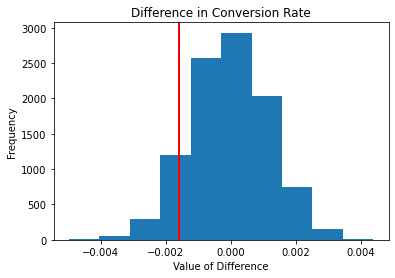

In [27]:
plt.hist(p_diffs)
plt.title("Difference in Conversion Rate")
plt.xlabel("Value of Difference")
plt.ylabel("Frequency")
plt.axvline(x=obs_diff, c='r', lw=2);

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [28]:
(np.array(p_diffs) > obs_diff).mean()

0.9025

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages?

**The p-value is greater than the significance level of 0.05, suggesting that the difference between the new and old page is not statistically significant, since 0.906 > 0.05**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [29]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[df2['landing_page']=='old_page'].converted.sum()

# number of conversions with the new_page
convert_new = df2[df2['landing_page']=='new_page'].converted.sum()

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page']=='old_page'].shape[0]

# number of individuals who received new_page
n_new = df2[df2['landing_page']=='new_page'].shape[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

In [30]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**The z-score and p-value confirm the results found in parts j. and k. as they suggest failing to reject the null hypothesis, which stated that $p_{new} - p_{old} <= 0$ and therefore this suggests that the conversion rate for the new page is less than or equal to the new page**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [31]:
df2['intercept'] = 1

# get_dummies stores the columns in alphabetical order, so they would be ['control', 'treatment']
# putting the control column in tmp to be dropped, and treatment in ab_page
df2[['tmp', 'ab_page']] = pd.get_dummies(df['group'])

# dropping the column that considers the control group as 1 and treatment as 0
df2 = df2.drop('tmp', axis=1)

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [32]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366121
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.9785
Date:               2022-09-18 15:49 BIC:              212803.1378
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.76389    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9980    0.0081  -246.9372  0.0000  -2.0138  -1.9821
ab_page       0.0034    0.0114     0.3004  0.7639  -0.0190   0.0258
==================================================================

"""

In [34]:
np.exp(results.params)

intercept    0.13561
ab_page      1.00344
dtype: float64

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

>1) The Null and Alternative Hypotheses associated with ab_page are:<br>

><div align="center">$H_0: β_1 = 0$</div><br>
><div align="center">$H_1: β_1 ≠ 0$</div><br>

>>Where $β_1$ is the coefficient of the independent variable representing ab_page (which is zero for the control group and one for the treatment group<br>

>2) This Hypothesis is two-sided since it assumes equality, and the p-value is 0.7639, which is greater than the significance level of 0.05.

>3) Statistically, This indicates that the coefficient of ab_page could be zero, and therefore that this independent variable may be insignificant. This is also evident in the Standard Error of the ab_page variable, which indicates that its value is 0.0034 ± 0.0114, This interval includes Zero<br>

**Practical Interpretation**: Since ab_page represents getting the new page or the old page, this p-value indicates that the page type has no significant effect on whether or not the person converts. This confirms the earlier reports that the conversion rate is not significally different between the old and new pages

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Considering Multiple Factors can increase accuracy of prediction, since not all things in life happen due to only one factor. However, adding multiple factors can break the calculations of the model and cause it to display results that don't make sense, since every model assumes certain properties regarding input data, if these properties do not exist for the factors entered, the results could be inaccurate.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [35]:
# Read the countries.csv
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
# Join with the df2 dataframe
df_merged = df2.join(countries_df.set_index('user_id'), on='user_id')

In [37]:
# Create the necessary dummy variables
df_merged[sorted(df_merged.country.unique())] = pd.get_dummies(df_merged['country'])

In [38]:
log_mod2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.7408
Date:               2022-09-18 15:49 BIC:              212825.0594
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.34378    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0393    0.0266  -76.5812  0.0000  -2.0915  -1.9871
ab_page        0.0035    0.0114    0.3042  0.7610  -0.0189   0.0259
UK             0.0507    0.0284    1.7869  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5180  0.1290  -0.0119   0.0935
==================================================================

"""

>**Statistically:** The Results provided in the summary indicate that both country and page factors are not statistically significant, as their p-values [0.76, 0.07, 0.13] are much greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis that states that they have no effect on the conversion rate

>**Practically:** All of the tests we have performed have given no evidence that the new landing page has a higher conversion rate. Therefore, It is recommended that the old webpage is kept.

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

In [39]:
# Fit your model, and summarize the results
df_merged['US_inter'] = df_merged['US'] * df_merged['ab_page']
df_merged['UK_inter'] = df_merged['UK'] * df_merged['ab_page']
log_mod_inter = sm.Logit(df_merged['converted'], df_merged[['intercept', 'US_inter', 'UK_inter', 'US', 'UK', 'ab_page']])
results_inter = log_mod_inter.fit()
results_inter.summary2()

Optimization terminated successfully.
         Current function value: 0.366101
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212778.4170
Date:               2022-09-18 15:49 BIC:              212841.8948
No. Observations:   290584           Log-Likelihood:   -1.0638e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.039884   
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -1.9992    0.0363  -55.0528  0.0000  -2.0704  -1.9280
US_inter       0.1019    0.0538    1.8947  0.0581  -0.0035   0.2073
UK_inter       0.0380    0.0568    0.6684  0.5039  -0.0734   0.1493
US            -0.0098    0.0376   -0.2613  0.7939  -0.0835   0.0639
UK             0.0319    0.0397    0.8039  0.4215  -0.0459   0.1096
ab_page       -0.0774    0.0520   -1.4887  0.1366  -0.1794   0.0245
==================================================================

"""

>**Statistically:** The Results provided in the summary indicate that the interaction of Country and Group is not a statistically significant factor, since the p-values [0.06, 0.51] are greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis that states that they have no effect on the conversion rate.

>**Practically:** All of the tests we have performed have given no evidence that the new landing page has a higher conversion rate. Therefore, It is recommended that the old webpage is kept.

<a id="conclusion"></a>
# Conclusion

>**Statistically:** Using three different methods, [Probability](#probability), [A/B Testing](#ab_test), and [Regression](#regression). There has not been enough statistical evidence to reject the Null Hypothesis that assumes that the conversion rate of the new page is less than or equal to that of the old page. Therefore, we fail to reject the Null Hypothesis.

>**Practically:** All of the tests we have performed have given no evidence that the new landing page has a higher conversion rate. Therefore, It is recommended that the old webpage is kept.

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1